In [47]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, Union, Optional, Iterable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from BenchmarkStrategy import BenchmarkStrategy
from MovingAverageStrategy import MovingAverageStrategy
from RSIStrategy import RSIStrategy
from MACDStrategy import MACDStrategy
from VolatilityBreakoutStrategy import VolatilityBreakoutStrategy


from pathlib import Path

### Helper Functions

In [48]:
def plot_cum_pnl_all_strategies(df_histories, as_pct=False, title="Cumulative PnL — All Strategies"):
    """
    Plots cumulative PnL across all strategies on one chart.

    Parameters
    ----------
    df_histories : pd.DataFrame
        MultiIndex by ["Strategy","Timestamp"], columns include either:
          - 'CumulativePnL', OR
          - 'Cash' and 'Holdings' (will compute TotalValue and baseline PnL)
    as_pct : bool
        If True, shows cumulative performance relative to the first timestamp (in %).
        If False, shows PnL in dollars.
    title : str
        Plot title.
    """
    # Work on a copy
    df = df_histories.copy()

    # Ensure we have TotalValue if needed
    if "CumulativePnL" not in df.columns:
        if "TotalValue" not in df.columns:
            if not {"Cash","Holdings"}.issubset(df.columns):
                raise ValueError("Need either 'CumulativePnL' or both 'Cash' and 'Holdings' in df_histories.")
            df["TotalValue"] = df["Cash"] + df["Holdings"]

    plt.figure(figsize=(10, 6))

    for strat, g in df.groupby(level="Strategy"):
        g = g.sort_index()  # sort by Timestamp within each strategy

        if "CumulativePnL" in g.columns:
            series = g["CumulativePnL"]
            ylab = "Cumulative PnL ($)"
        else:
            # Baseline from first TotalValue per strategy
            first_val = g["TotalValue"].iloc[0]
            if as_pct:
                series = (g["TotalValue"] / first_val - 1.0) * 100.0
                ylab = "Cumulative Return (%)"
            else:
                series = g["TotalValue"] - first_val
                ylab = "Cumulative PnL ($)"

        # x-axis is the Timestamp level
        x = g.index.get_level_values("Timestamp")
        plt.plot(x, series, label=strat, linewidth=2)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylab)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [49]:
def load_strategy_histories(strategies) -> pd.DataFrame:
    base_dir = Path.cwd().parent

    perf_dir = base_dir / "Assignment_2_Results"
    perf_dir.mkdir(parents=True, exist_ok=True)  # ensure folder exists

    dfs = []

    for s in strategies:
        name = s.__class__.__name__
        file_path = perf_dir / f"{name}_portfolio_history.csv"

        if not file_path.exists():
            print(f"[WARN] File not found for {name}: {file_path}")
            continue

        df = pd.read_csv(file_path, parse_dates=["Timestamp"])
        df["Strategy"] = name
        dfs.append(df)


    if not dfs:
        raise FileNotFoundError("No strategy performance files found in data/prices/")

    df_all = pd.concat(dfs, ignore_index=True)
    df_all.sort_values(by=["Timestamp", "Strategy"], inplace=True)

    return df_all

In [50]:
def plot_total_value_all_strategies(df_histories):
    plt.figure(figsize=(10,6))
    colors = plt.cm.tab10.colors  # auto palette

    for i, (strategy, group) in enumerate(df_histories.groupby(level="Strategy")):
        g = group.sort_index()
        if "TotalValue" not in g.columns:
            g = g.assign(TotalValue=g["Cash"] + g["Holdings"])
        plt.plot(g.index.get_level_values("Timestamp"), g["TotalValue"],
                 label=strategy, color=colors[i % len(colors)], linewidth=2)

    plt.title("Total Portfolio Value Across Strategies")
    plt.xlabel("Date")
    plt.ylabel("Dollars ($)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [51]:
def strategy_cash_holdings_tv(df_histories, strategy):
    """
    Plots a compact chart of Cash, Holdings, and Total Value for one strategy.
    """
    # Extract that strategy’s data
    g = df_histories.xs(strategy, level="Strategy").sort_index()

    # Compute Total Value if missing
    if "TotalValue" not in g.columns:
        g = g.assign(TotalValue=g["Cash"] + g["Holdings"])

    # Create small figure
    plt.figure(figsize=(5, 3))
    plt.plot(g.index.get_level_values("Timestamp"), g["Cash"], color="black", label="Cash")
    plt.plot(g.index.get_level_values("Timestamp"), g["Holdings"], color="blue", label="Holdings")
    plt.plot(g.index.get_level_values("Timestamp"), g["TotalValue"], color="green", label="Total Value")

    plt.title(strategy, fontsize=10)
    plt.xlabel("")
    plt.ylabel("Value ($)")
    plt.legend(fontsize=7, loc="best")
    plt.tight_layout()
    plt.show()

### Load Results from all strategies

In [52]:
strategies = [BenchmarkStrategy(),
                 MovingAverageStrategy(), 
                 RSIStrategy(),
                 MACDStrategy() , 
                 VolatilityBreakoutStrategy()
                    ]

df_histories = load_strategy_histories(strategies).reset_index(drop=True)

cols = ["Strategy"] + [c for c in df_histories.columns if c != "Strategy"]
df_histories = df_histories[cols]

df_histories = df_histories.set_index(["Strategy", "Timestamp"]).sort_index()

df_histories["Total Value"] = df_histories["Cash"] + df_histories["Holdings"]

df_histories.head(10)

Cash  Holdings  Total Value
Strategy          Timestamp                                                  
BenchmarkStrategy 2025-09-21 19:54:01.774173  998506.5    1493.5    1000000.0
                  2025-09-21 19:54:02.003341  998506.5    1728.3    1000234.8
                  2025-09-21 19:54:03.005285  998506.5    1969.3    1000475.8
                  2025-09-21 19:54:04.010322  998506.5    2571.9    1001078.4
                  2025-09-21 19:54:05.014941  998506.5    2162.6    1000669.1
                  2025-09-21 19:54:06.000745  998506.5    1687.3    1000193.8
                  2025-09-21 19:54:07.003483  998506.5    1755.7    1000262.2
                  2025-09-21 19:54:08.011916  998506.5    1790.4    1000296.9
                  2025-09-21 19:54:09.011799  998506.5    2049.7    1000556.2
                  2025-09-21 19:54:09.484416  998506.5    2462.1    1000968.6

## Plot 1: Signal Overlay on Price Chart

In [ ]:
def load_market_price_data(file_path: Path) -> pd.DataFrame:
    """Load price data from market_data.csv for price chart."""
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

def extract_signals_from_portfolio_history(portfolio_history: pd.DataFrame) -> pd.DataFrame:
    """
    Extract buy signals by detecting when holdings increase significantly.
    This approximates signal generation based on portfolio changes.
    """
    history = portfolio_history.copy()
    history = history.set_index('Timestamp').sort_index()
    
    # Calculate change in holdings
    history['HoldingsChange'] = history['Holdings'].diff()
    
    # Define signals as significant increases in holdings (>100 units threshold)
    signals = history[history['HoldingsChange'] > 100].reset_index()
    
    return signals

def plot_signal_overlay(strategy_name: str, market_data: pd.DataFrame, portfolio_history: pd.DataFrame):

    price_df = market_data.copy()
    price_df['timestamp'] = pd.to_datetime(price_df['timestamp'])
    
    # Group by timestamp and take first price (assuming single symbol or average)
    price_agg = price_df.groupby('timestamp')['price'].first().reset_index()
    price_agg = price_agg.set_index('timestamp')
    
    # Extract signals from portfolio history
    signals = extract_signals_from_portfolio_history(portfolio_history)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), height_ratios=[3, 1])
    
    # Plot 1: Price chart with signal markers
    ax1.plot(price_agg.index, price_agg['price'], 'b-', linewidth=1.5, alpha=0.7, label='Price')
    
    # Overlay buy signals
    if len(signals) > 0:
        for _, signal_row in signals.iterrows():
            timestamp = signal_row['Timestamp']
            # Find corresponding price
            if timestamp in price_agg.index:
                price = price_agg.loc[timestamp, 'price']
                ax1.scatter(timestamp, price, color='green', marker='^', 
                           s=150, zorder=5, alpha=0.8, label='Buy Signal' if _ == signals.index[0] else '')
    
    ax1.set_title(f'{strategy_name}: Price Chart with Buy Signals', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Holdings over time to show when signals occurred
    ax2.plot(portfolio_history.set_index('Timestamp')['Holdings'], 'g-', linewidth=1.5)
    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Holdings ($)')
    ax2.set_title('Portfolio Holdings Over Time', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
def plot_signal_overlay_for_strategy(strategy_name: str):
    """Helper to plot signal overlay for a specific strategy."""
    base_dir = Path("../")
    
    # Load market data
    market_data = load_market_price_data(base_dir / "data/market_data.csv")
    
    # Load portfolio history
    portfolio_path = base_dir / "Assignment_2_Results" / f"{strategy_name}_portfolio_history.csv"
    portfolio_history = pd.read_csv(portfolio_path, parse_dates=['Timestamp'])
    
    plot_signal_overlay(strategy_name, market_data, portfolio_history)


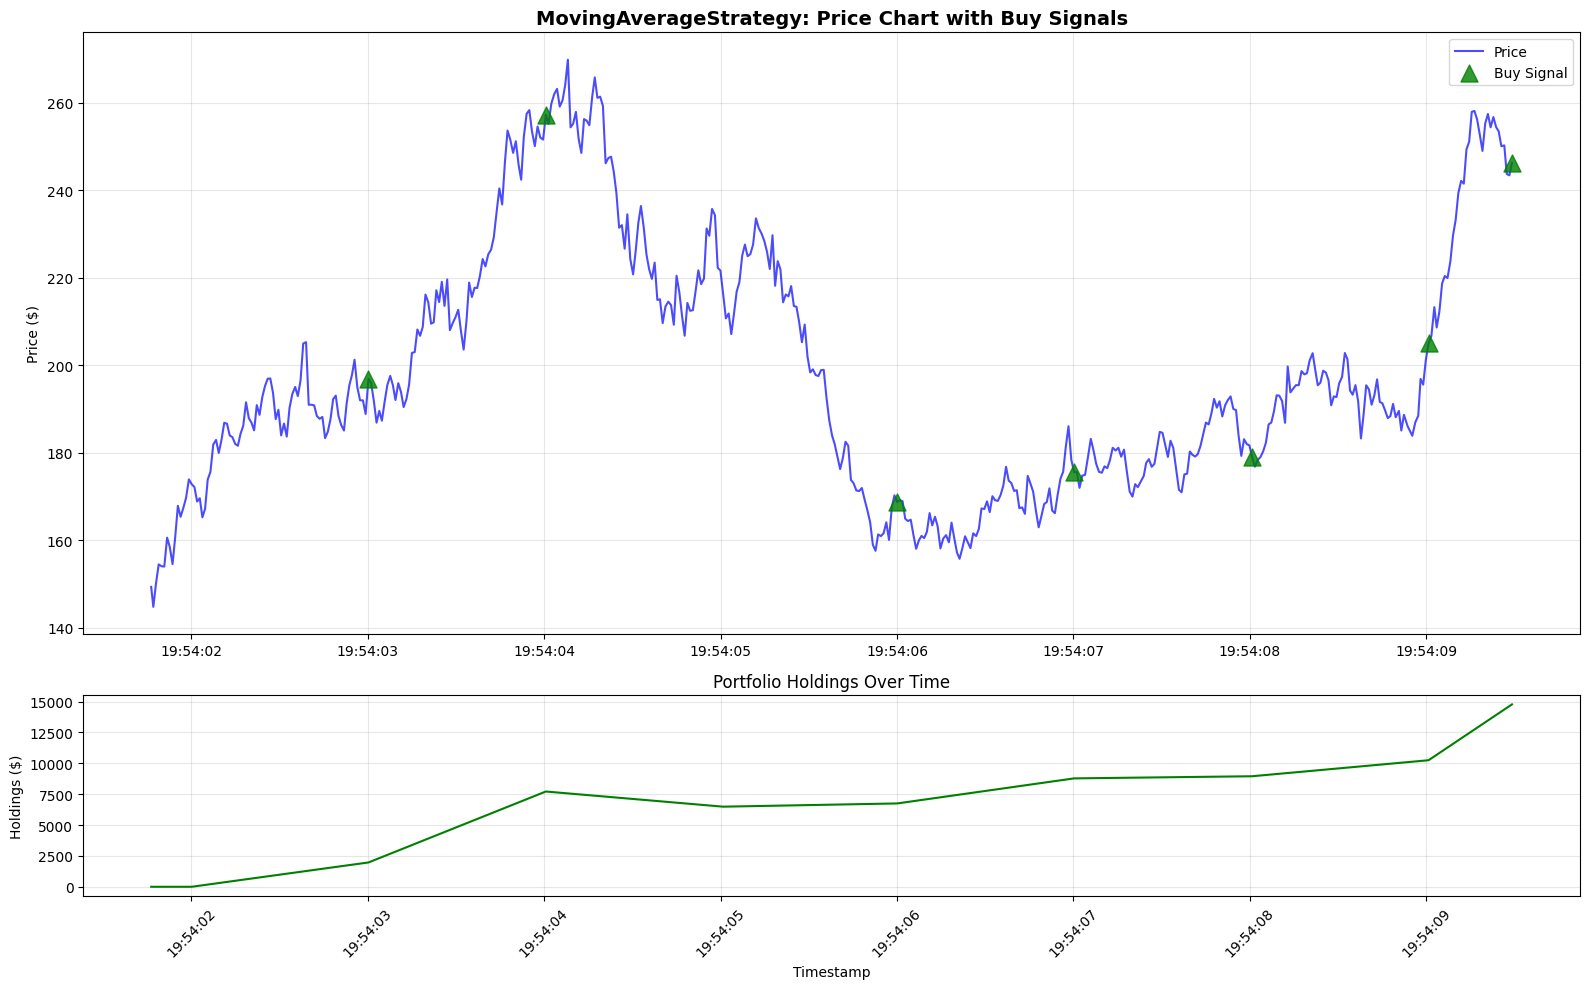

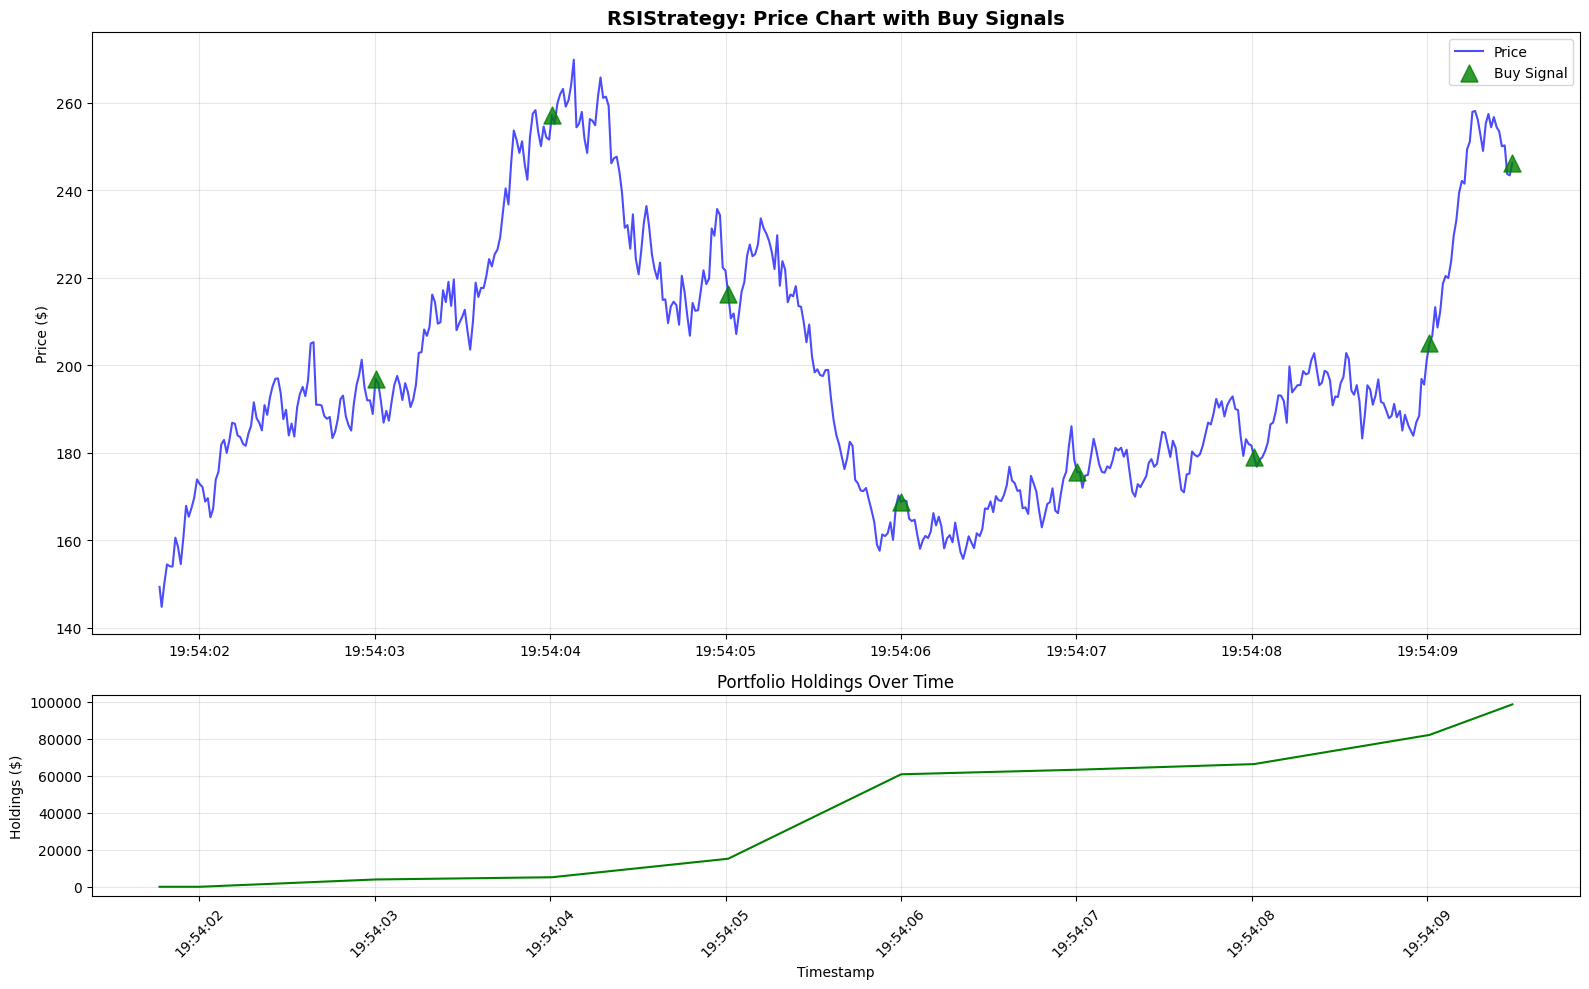

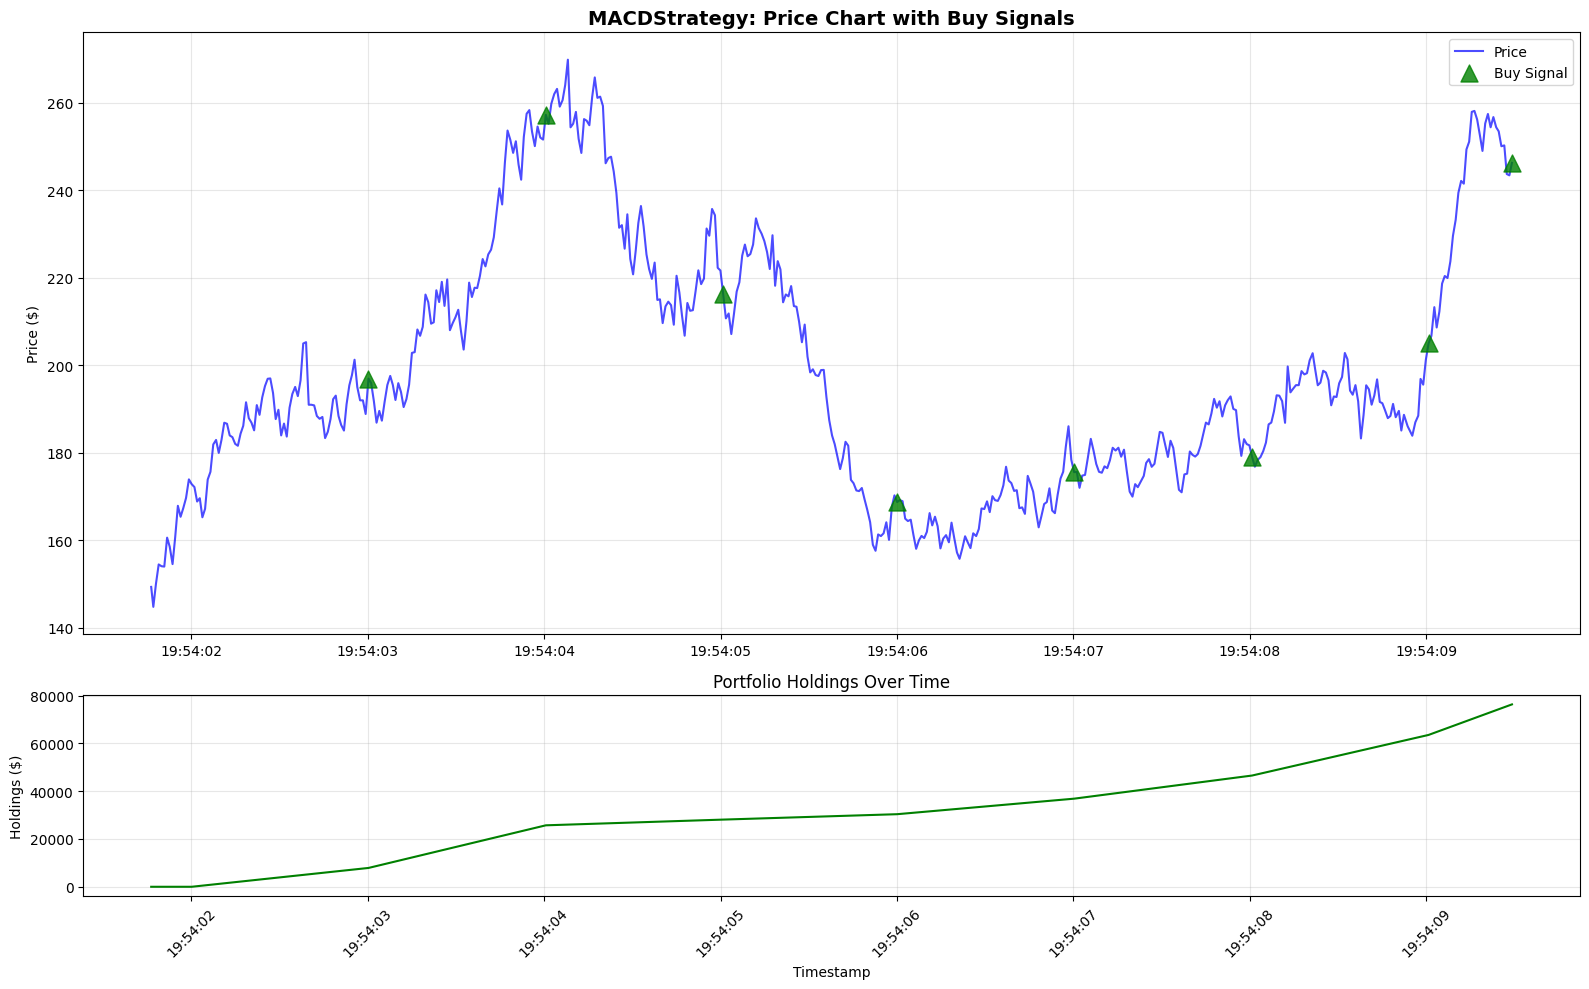

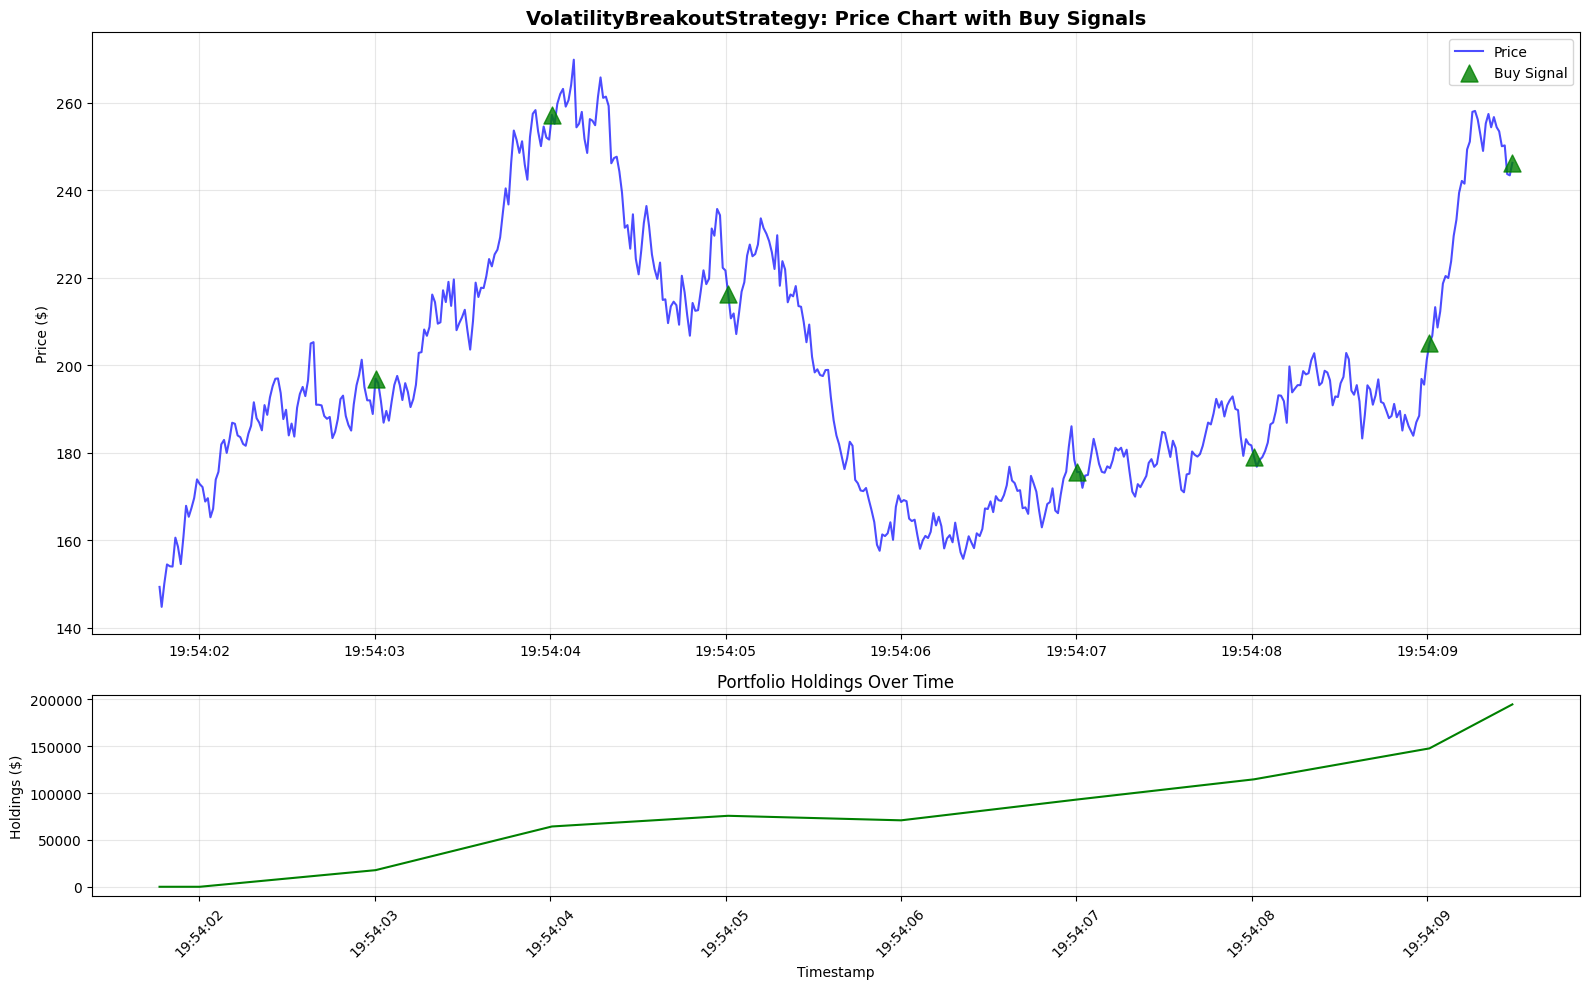

In [54]:
# Plot signal overlay for each strategy
for strat in ["MovingAverageStrategy", "RSIStrategy", "MACDStrategy", "VolatilityBreakoutStrategy"]:
    try:
        plot_signal_overlay_for_strategy(strat)
    except Exception as e:
        print(f"Error plotting {strat}: {e}")
        pass


## Plot 2: Portfolio Value Over Time

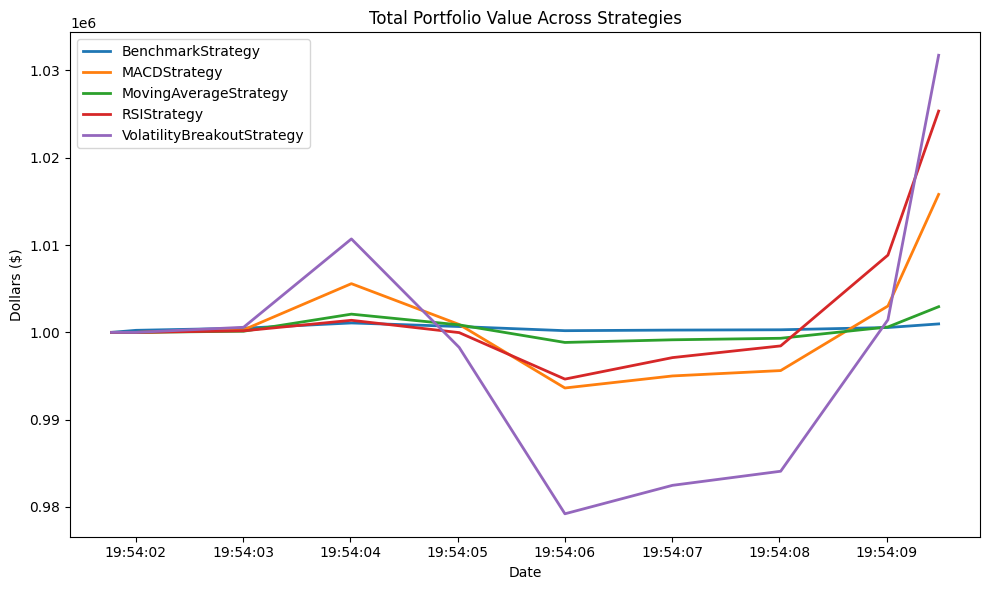

In [55]:
plot_total_value_all_strategies(df_histories)

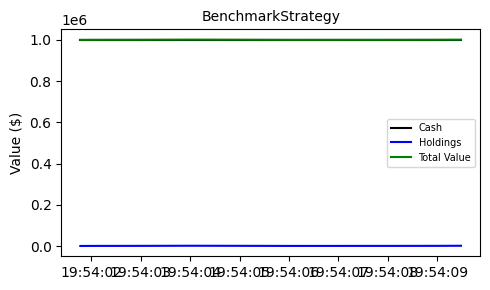

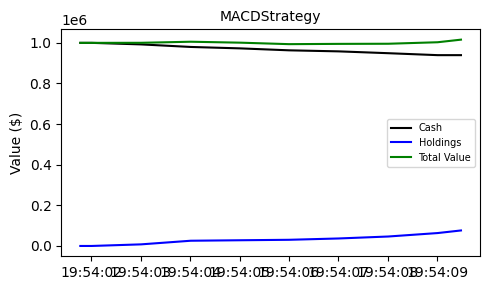

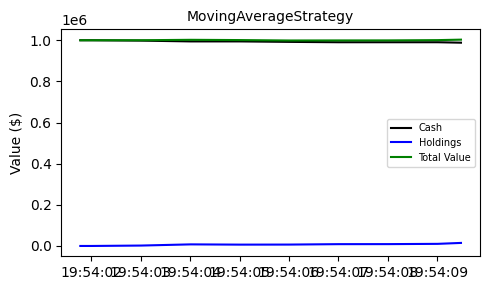

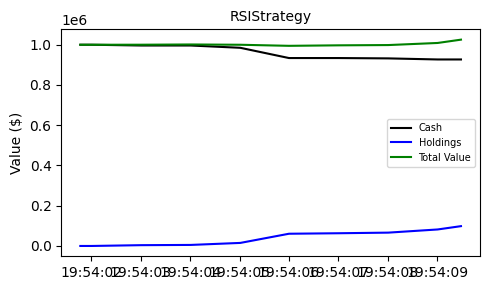

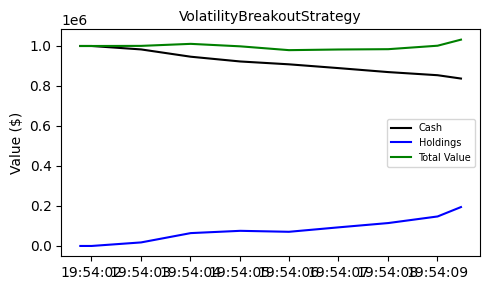

In [56]:
for strat in df_histories.index.get_level_values("Strategy").unique():
    strategy_cash_holdings_tv(df_histories, strat)

## Plot 3: Compare Cumulative PnL Across Strategies

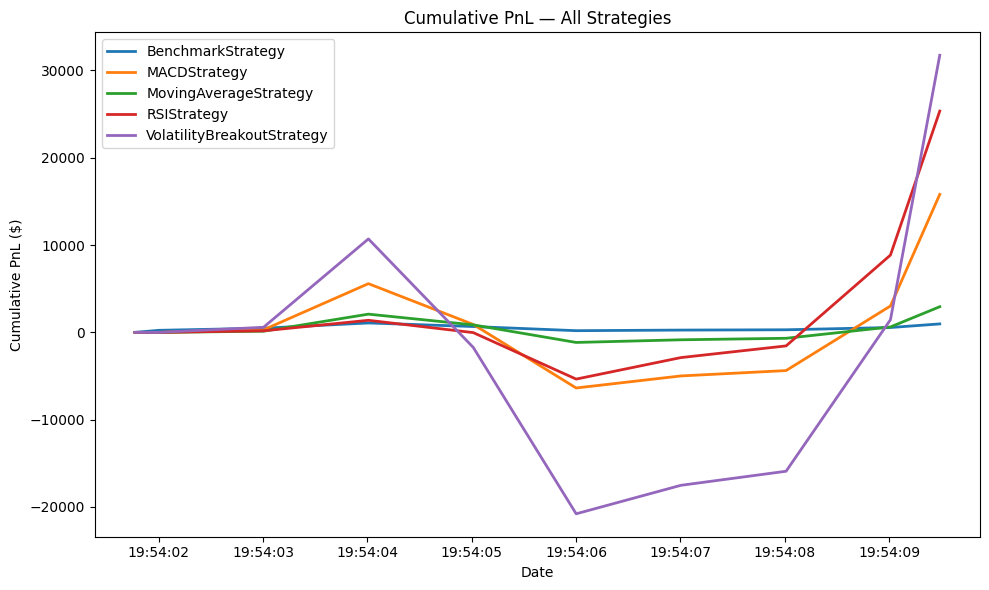

In [57]:
plot_cum_pnl_all_strategies(df_histories, as_pct=False)

### Analysis Summary


**Key Findings:**
1. **VolatilityBreakoutStrategy** had the highest return of +3.17% ($31,741 P&L) and 79 trades, accumulating 790 shares. However, it had the worst max drawdown at -14.61%, indicating high volatility. The volatility of this strategy can be seen in Plot 2.
2. **RSIStrategy** had the second highest return of +2.53% ($25,347) and 40 trades (400 shares), but also had significant drawdown at -7.31%
3. **MovingAverageStrategy** was the most conservative with only 6 trades, +0.29% return ($2,939), minimal drawdown (-0.96%), suggesting quality over quantity

**Which strategy performed best and why:**
- **VolatilityBreakoutStrategy** achieved the highest absolute return (+3.17%) and built the largest position (790 shares worth $194,505.90). It was most aggressive in taking advantage of volatility spikes, buying during price breakouts. However, its high drawdown (-14.61%) and negative Sharpe ratio indicate high risk/reward.
- **RSIStrategy** showed good profitability (+2.53%) through buying oversold conditions, executing 40 trades and holding 400 shares worth $98,484. This strategy effectively bought the dip multiple times.
- **MACDStrategy** (+1.58%) was selective with 31 trades, holding 310 shares. It had better risk metrics (drawdown: -6.05%) than VolatilityBreakout but still negative Sharpe ratio.
- **MovingAverageStrategy** (+0.29%) was most disciplined, only executing 6 trades when clear crossovers occurred, resulting in minimal risk (drawdown: -0.96%, Sharpe: -0.90) but also minimal returns.

**Execution constraint impact:**
- All strategies successfully used their $1M starting capital, but **VolatilityBreakout depleted cash most** (ending with $837,235.10 cash vs $194,505.90 in holdings), demonstrating the most capital efficiency
- **MovingAverage** and **Benchmark** held onto cash (Benchmark: $998,506.50), suggesting conservative signal generation vs RSI/MACD/VolatilityBreakout who deployed capital more aggressively
- The 100 share fixed quantity per trade meant strategies that generated many signals (VolatilityBreakout: 79 trades) could accumulate significant positions (790 shares)
- No shorting constraint meant strategies could only profit from upward movements, which worked well in this market period

**Signal behavior insights:**
- **VolatilityBreakout** was most reactive to price changes, generating 79 signals to buy at volatility breakouts
- **RSIStrategy** generated 40 signals by buying at oversold conditions (RSI < 30), showing counter-trend behavior
- **MACDStrategy** generated 31 signals using momentum confirmation (MACD cross above signal), more selective than RSI
- **MovingAverage** generated only 6 signals, waiting for clear 20MA/50MA crossovers, most conservative approach

**Recommendations for improvement:**
1. **Risk management**: VolatilityBreakout's high drawdown (-14.61%) suggests adding stop-losses or position sizing rules
2. **Cash management**: Consider implementing position limits to prevent over-allocation (VolatilityBreakout used $162,764.90 of capital very aggressively)
3. **Combine strategies**: MACD's selectivity with RSI's entry timing could improve risk-adjusted returns
4. **Track Sharpe ratio**: All strategies show negative Sharpe ratios, suggesting high volatility or poor timing relative to risk-free rate
5. **Add exit signals**: Current strategies only buy; adding sell signals based on technical indicators could improve returns and reduce drawdowns
